In [1]:
import numpy as np
import os
import random


import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import PIL.Image
from read_HiC import name_chromosomes
import seaborn as sns
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

import sys
path=r'C:\Users\31649\Documents\genome analysis\genome_topology\functions'
sys.path.append(path)

from plotting_tools import set_layout
from genome_topology import normalize_psc
from genome_topology import get_matrix
from genome_topology import fractal_dimension
from genome_topology import make_graph
from plotting_tools import save_figures
from matrix_analysis import PlotMatrix_SelectFraction
from matrix_analysis import Select_entangled_fraction
from statistical_analysis import comparison_distributions
from statistical_analysis import find_peaks_distribution

## Length scale analysis
Code to read, plot and analyze CT parameters from cumulative analysis. We attempted to find local maxima in the traces, to calculate characteristic length scales, but this bulk Hi-C dataset does not look to be suitable for this type of analysis. Subsequently, we calculated the convergence threshold of the clustering coefficient trace. The analysis revealed no statistical difference between control and curaxin data.

Pick resolution and increment of the cumulative traces. Choose what chromosome you want to analyze.

In [3]:
resolution = '80'
path_data = f'results counts/cumulative/{resolution}'
increment_setting = 50

cutoff = '0.99'
samples = ['Control1', 'Control2', 'Treated1', 'Treated2']
chrom = '2'

control1 = pd.DataFrame()
control2 = pd.DataFrame()
treated1 = pd.DataFrame()
treated2 = pd.DataFrame()

frames = [None]*4

for ind, sample in enumerate(samples):
    df =  pd.read_feather(f'{path_data}/cumulative_{sample}_{chrom}_{resolution}_{cutoff}.feather')
    
    
    frames[ind] = df.dropna().reset_index(drop=True)
    sample_col = [sample]* len(frames[ind])
    frames[ind]['Sample'] = sample_col
    
    
control1 = frames[0]
control2 = frames[1]
treated1 = frames[2]
treated2 = frames[3]

#Make unified dataset from control and curaxin data

dfs = [control1, control2, treated1, treated2]
df = pd.concat(dfs)

In [4]:
#Set figure parameters
set_layout(18, 18, 18)

## Plot traces

increment and increment_increase are parameters for distanciating the traces from different samples, in case the overlap made it difficult to visualize the feature of each trace.
Choose which parameter you want to visualize.

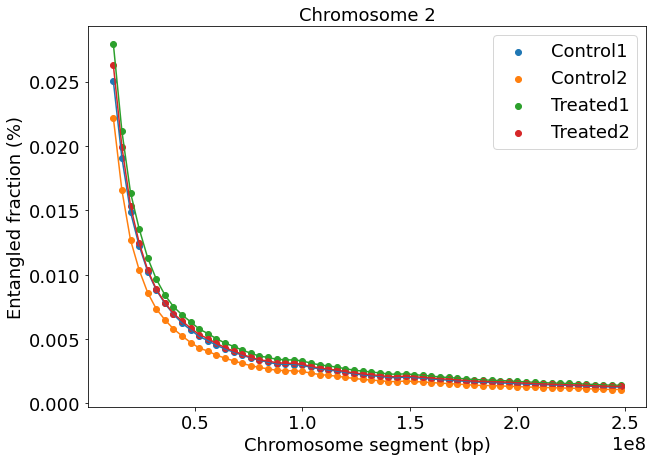

In [11]:
path_figure = f'results counts/figures/{resolution}/cumulative'
parameter = 'Cross (%)'
increment = 0
increment_increase = 0.0
plot = plt.figure(figsize = (10, 7))

for sample in samples:
    df_sample = df[df['Sample'] == sample]
    x = np.array(df_sample['Cut-off'])
    y = np.array(df_sample[parameter])
    
    y = y + increment
    
    plt.title(f'Chromosome {chrom}')
    plt.scatter(x, y, label = sample)
    plt.plot(x, y)
    plt.ylabel('Entangled fraction (%)')
    plt.xlabel('Chromosome segment (bp)')
    
    increment = increment + increment_increase
    
plt.legend(bbox_to_anchor=(1, 1))     


#save_figures(plot, path = path_figure, name_file = f'clustcoeff_{chrom}', method= increment_setting)

## Look for local maxima in the entangled fraction trace
If more local maxima are found, it is possible to calculate the distance between these maxima by decommenting the code

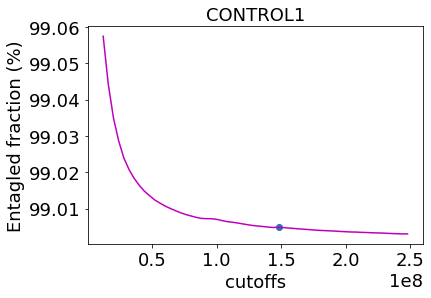

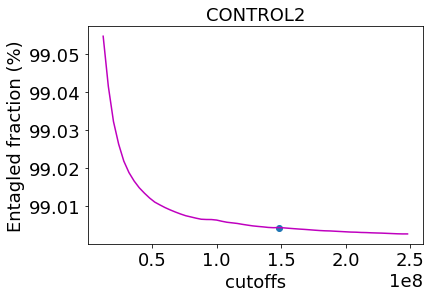

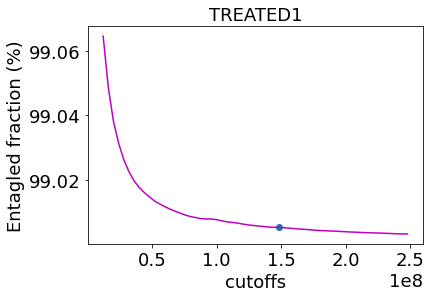

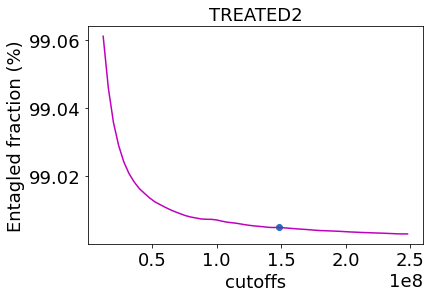

In [14]:
save_fig= False
plot_fig= 1
window=3
polynomial=2

distance_allchr=[]
sel_threshold=0
sel_prominence=0.00001



for sample in samples:
    df_sample = df[df['Sample'] == sample]

    atoms=np.array(df_sample['Cut-off'])
    series=np.array(df_sample['Series (%)'])
    filt_series=savgol_filter(series, window,polynomial)
    fract_ent=np.copy(100-filt_series)
    peak= find_peaks(fract_ent, threshold=sel_threshold, prominence=sel_prominence)
    array=np.array(peak[0])
    
    #Calculate distance between local maxima
    
    #dist=np.zeros(len(array)-1)
    #for m in range(len(dist)):
    #    dist[m]=atoms[array[m+1]]-atoms[array[m]]
    #for j in range(len(dist)):
    #    distance_allchr.append(dist[j])    
       
    if plot_fig:
        fig = plt.figure()
        plt.plot(atoms, fract_ent, color='m', label='Filtered entangled fraction')
        plt.scatter(atoms[array],fract_ent[array], label='Local maxima')
        string_title = f'{sample}'
        plt.title(string_title.upper())
        plt.xlabel('cutoffs')
        plt.ylabel('Entagled fraction (%)')    
        
        if save_fig:
            save_figures(fig,path_results, name_file = 'Chromosome {}'.format(letter))

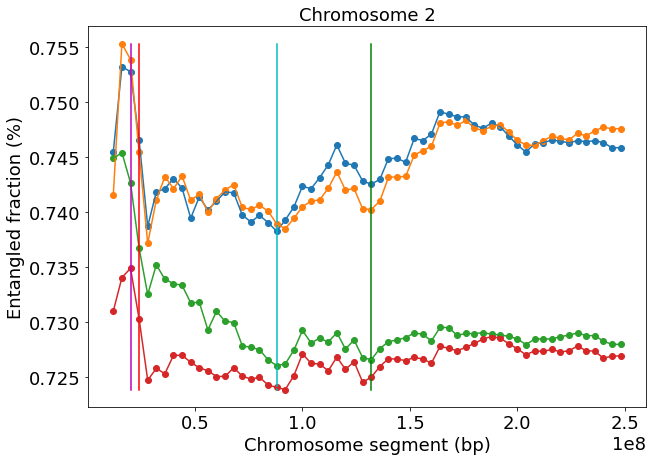

In [290]:
plot = plt.figure(figsize = (10, 7))
thresh = np.zeros(len(samples))
colors = ['c', 'g', 'r', 'm']
std_number = 2


y_max = np.max(np.array(df['Clustering coeff']))
y_min = np.min(np.array(df['Clustering coeff']))

for t, sample in enumerate(samples):
    df_sample = df[df['Sample'] == sample]
    x = np.array(df_sample['Cut-off'])
    y = np.array(df_sample['Clustering coeff'])
    
    std = np.std(y)
    mean_y = y[-1]
    for y_element in range(len(y)):
        if (y[y_element] <  (mean_y - std_number * std) or y[y_element] > (mean_y + std_number * std)):
            thresh[t] = x[y_element]
            
    plt.title(f'Chromosome {chrom}')
    plt.scatter(x, y, label = sample)
    plt.plot(x, y)
    plt.ylabel('Entangled fraction (%)')
    plt.xlabel('Chromosome segment (bp)')
    
    #Make vertical line for quantile threshold
    y_line = np.linspace(y_min, y_max, 10)
    x_line = np.ones(10)*thresh[t]
    plt.plot(x_line, y_line, color = colors[t])

In [15]:
df

,Cut-off,Parallel (%),Series (%),Cross (%),Clustering coeff,Sample
0,12000000,0.032389,0.942558,0.025053,0.745453,Control1
1,16000000,0.025040,0.955886,0.019074,0.753187,Control1
2,20000000,0.020057,0.965083,0.014860,0.752712,Control1
3,24000000,0.016406,0.971335,0.012258,0.746490,Control1
4,28000000,0.013725,0.976038,0.010237,0.738676,Control1
...,...,...,...,...,...,...
55,232000000,0.001853,0.996755,0.001392,0.727377,Treated2
56,236000000,0.001818,0.996818,0.001364,0.727346,Treated2
57,240000000,0.001781,0.996883,0.001336,0.726694,Treated2
58,244000000,0.001765,0.996914,0.001321,0.726902,Treated2


## Calculate convergence threshold

This technique is shown here on the Clustering Coefficient cumulative trace.
The convergence threshold is calculated in number of standard deviations (select std_number)

C:\Users\31649\AppData\Local\Temp\ipykernel_23924\4153912074.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plot = plt.figure(figsize = (10, 7))


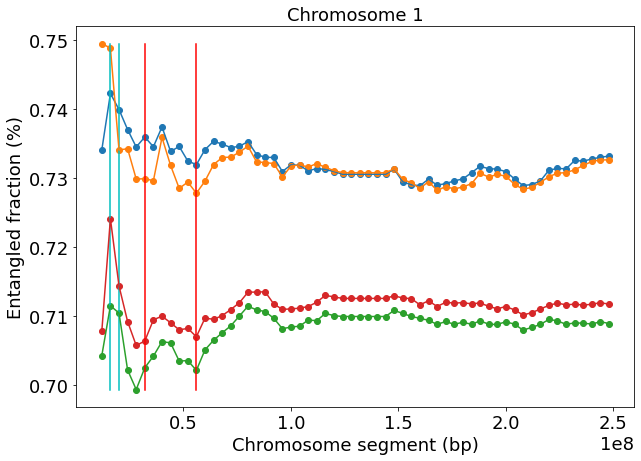

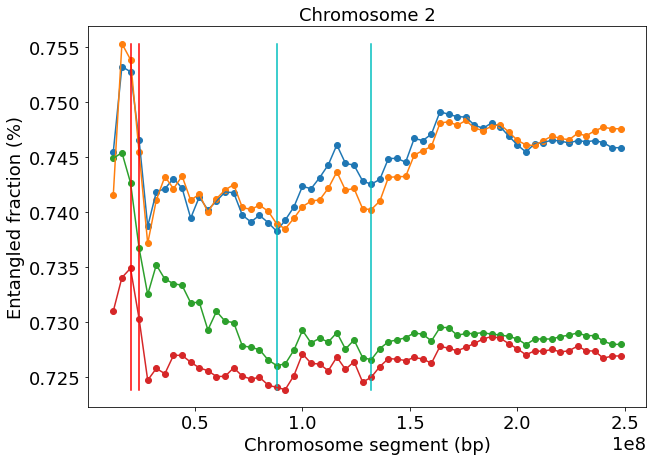

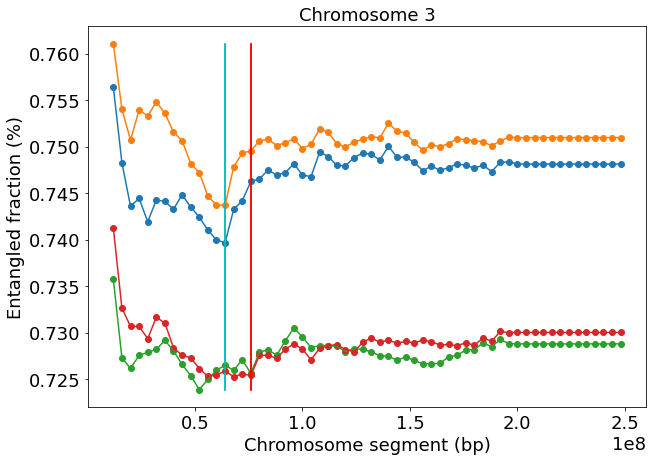

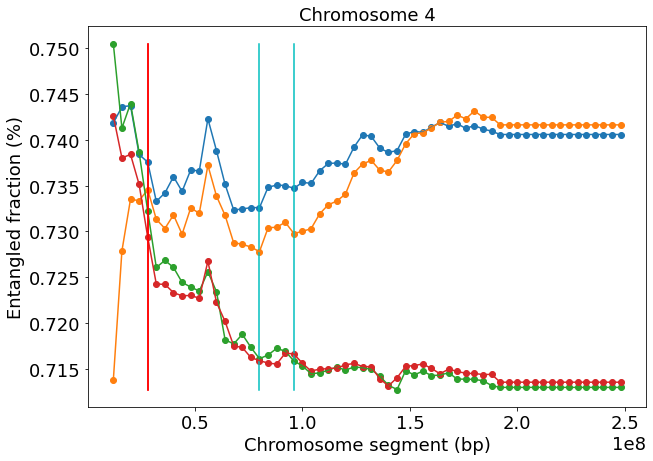

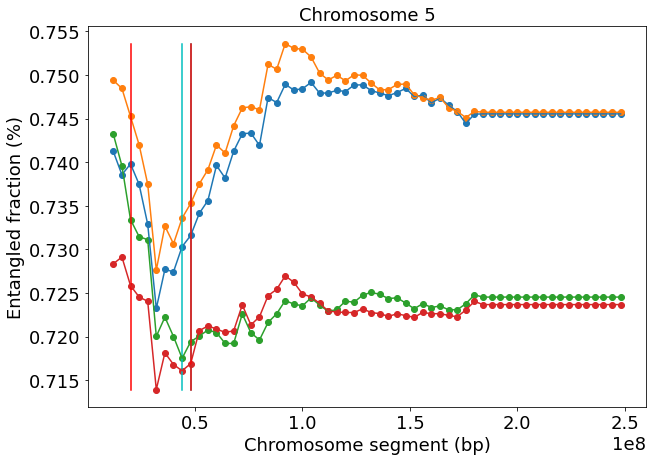

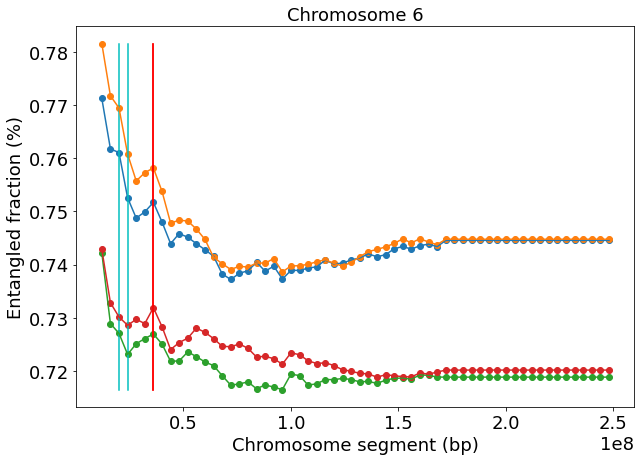

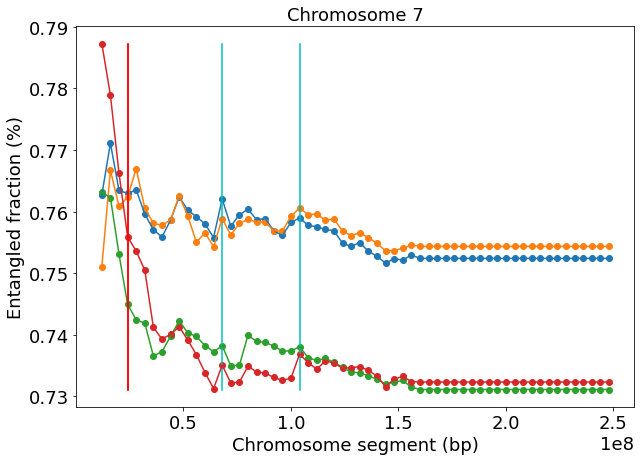

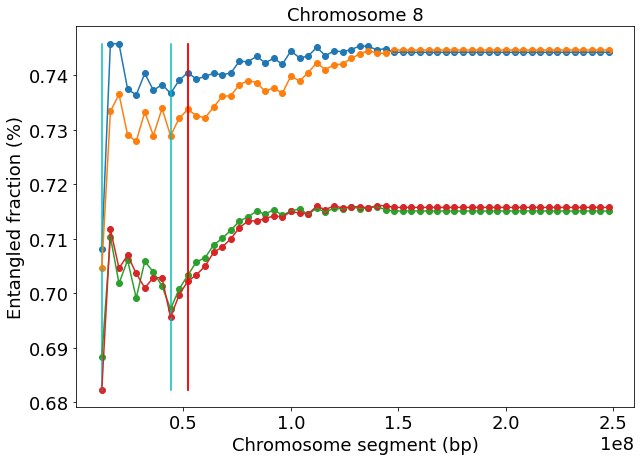

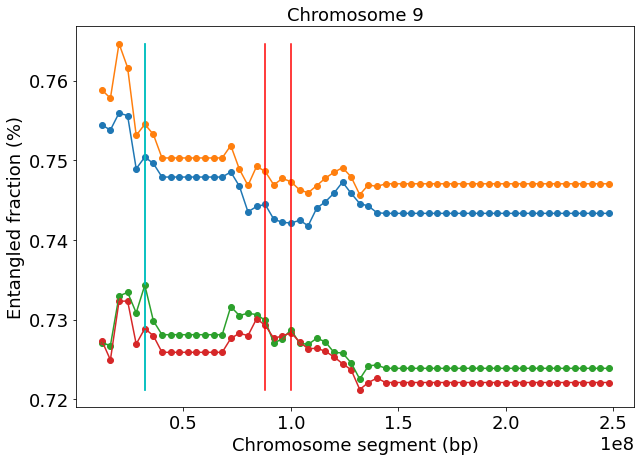

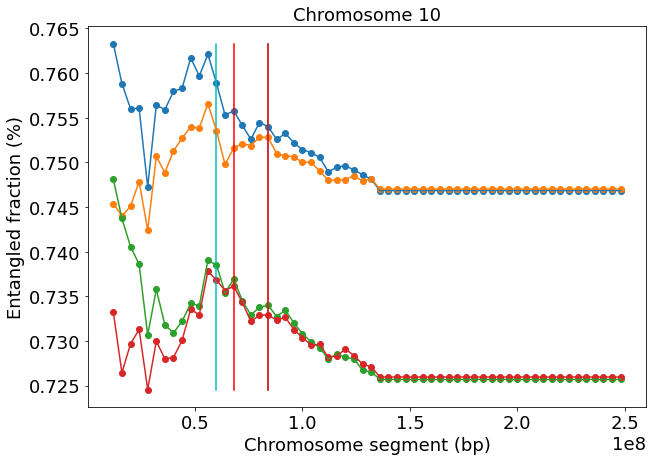

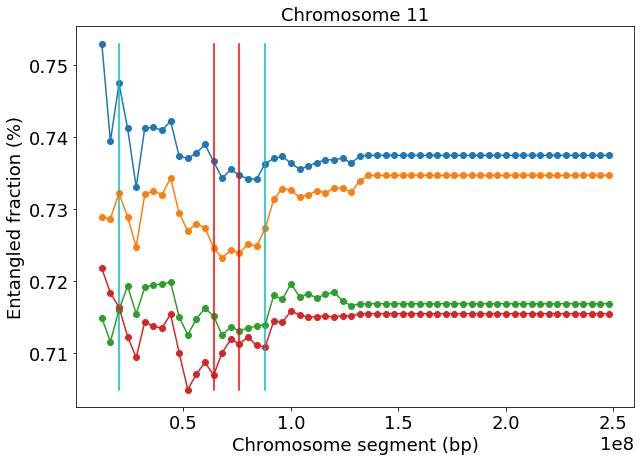

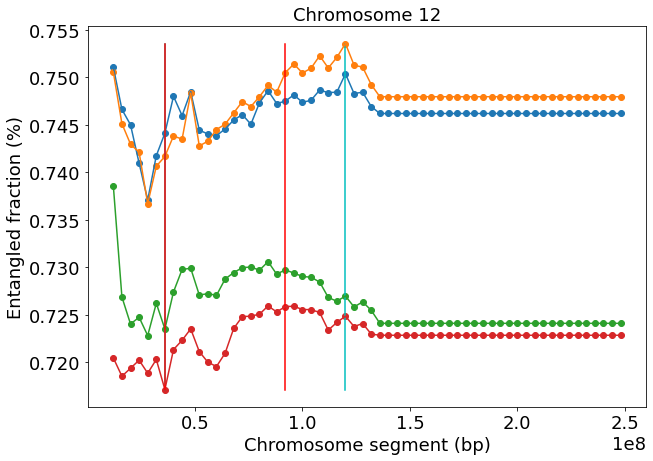

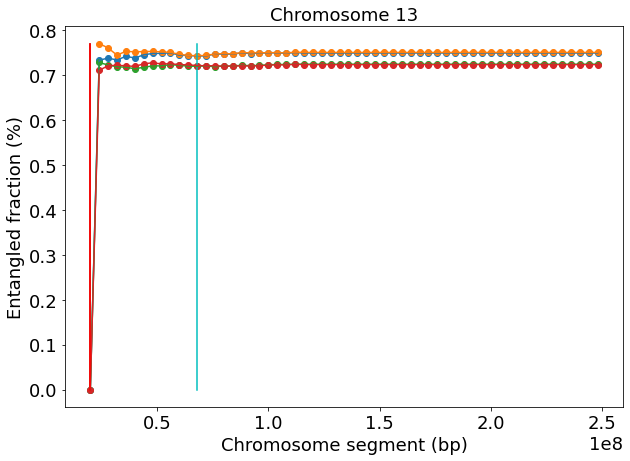

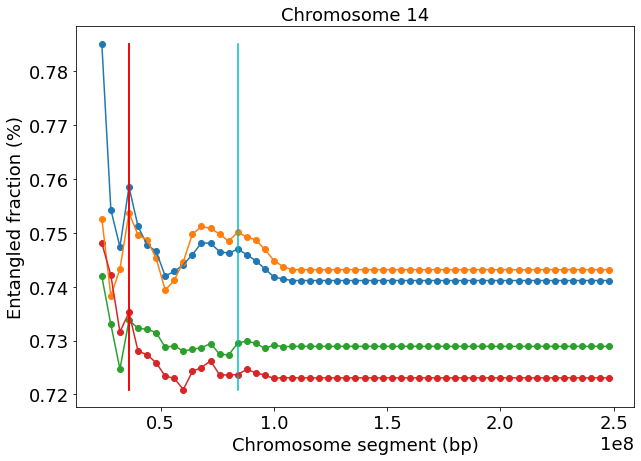

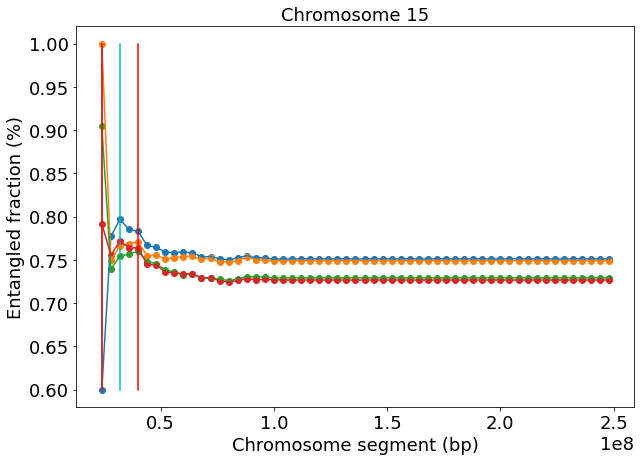

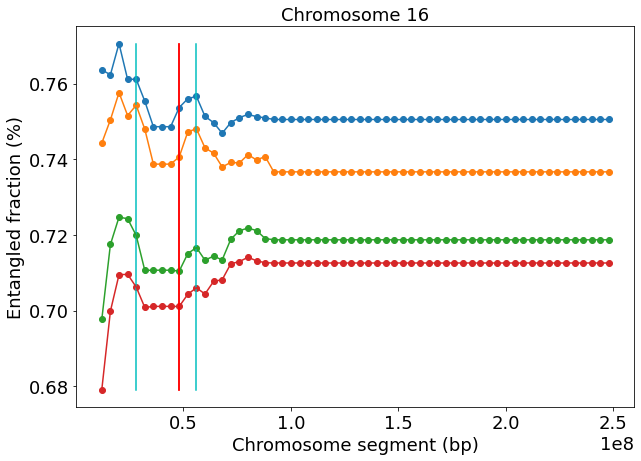

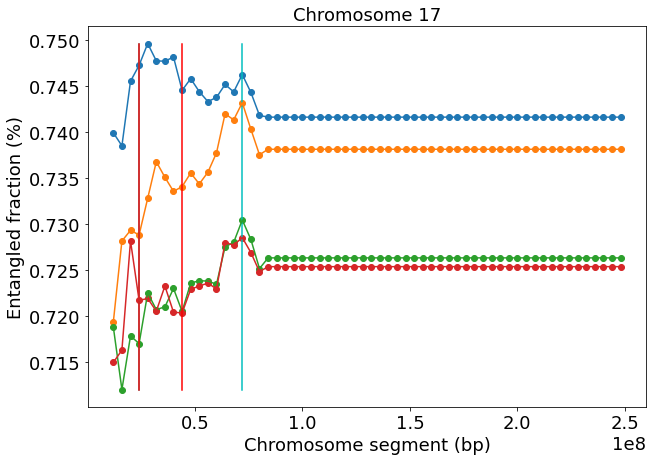

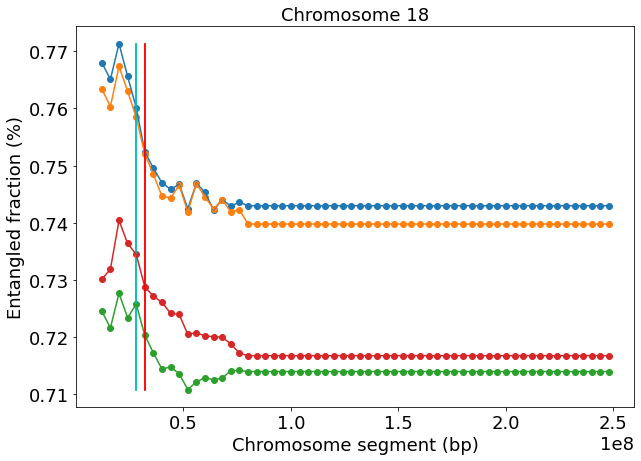

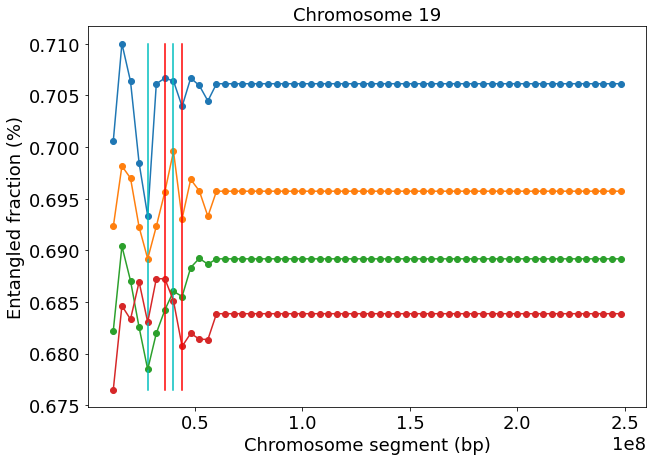

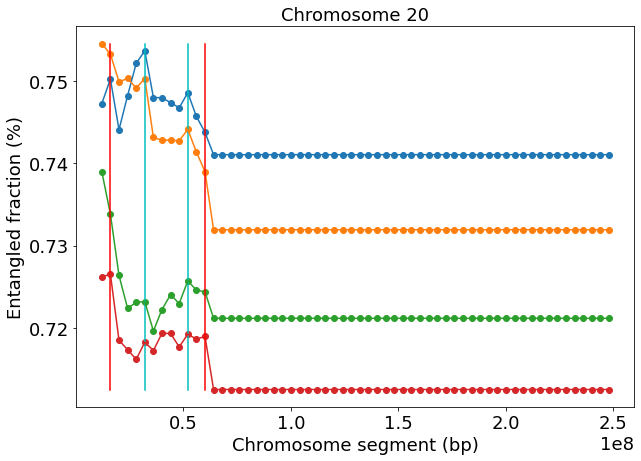

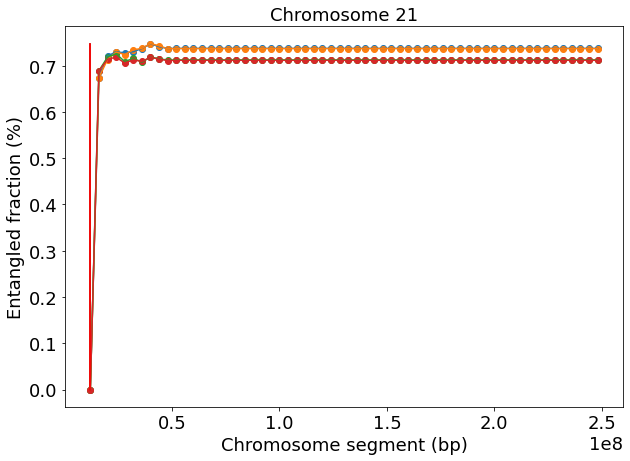

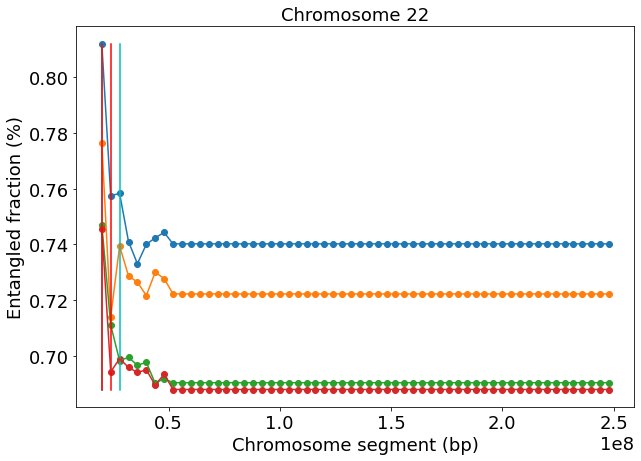

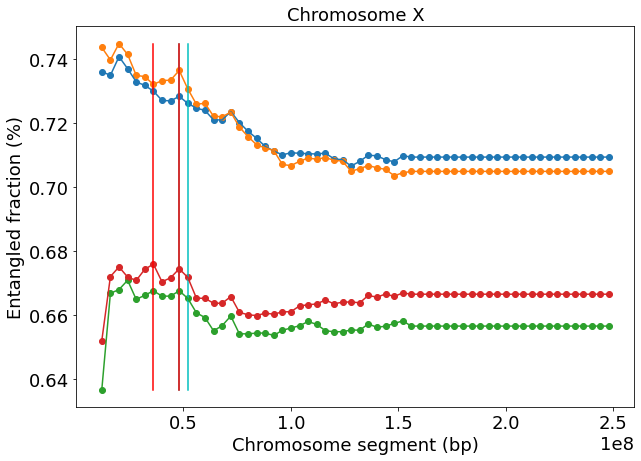

In [18]:
#Define name chromosomes
chromosomes = [str(num) for num in range(1,23)]
chromosomes += 'X'

#Choose convergence threshold
std_number = 2

thresh_chrom = []
for chrom in chromosomes:
    
    control1 = pd.DataFrame()
    control2 = pd.DataFrame()
    treated1 = pd.DataFrame()
    treated2 = pd.DataFrame()

    frames = [None]*4

    for ind, sample in enumerate(samples):
        df =  pd.read_feather(f'{path_data}/cumulative_{sample}_{chrom}_{resolution}_{cutoff}.feather')
    
    
        frames[ind] = df.dropna().reset_index(drop=True)
        sample_col = [sample]* len(frames[ind])
        frames[ind]['Sample'] = sample_col
        
    control1 = frames[0]
    control2 = frames[1]
    treated1 = frames[2]
    treated2 = frames[3]
        
    dfs = [control1, control2, treated1, treated2]
    df = pd.concat(dfs)
        
    plot = plt.figure(figsize = (10, 7))
    thresh = np.zeros(len(samples))
    colors = ['c', 'c', 'r', 'r']


    y_max = np.max(np.array(df['Clustering coeff']))
    y_min = np.min(np.array(df['Clustering coeff']))
    
    #print(chrom)
     
    thresh_sample = []    
    for t, sample in enumerate(samples):
        df_sample = df[df['Sample'] == sample]
        x = np.array(df_sample['Cut-off'])
        y = np.array(df_sample['Clustering coeff'])
    
        std = np.std(y)
        mean_y = y[-1]
        for y_element in range(len(y)):     
            if (y[y_element] <  (mean_y - std_number * std) or y[y_element] > (mean_y + std_number * std)):
                thresh[t] = x[y_element]
        
        #print(thresh[t])
        thresh_sample.append(thresh[t])
        plt.title(f'Chromosome {chrom}')
        plt.scatter(x, y, label = sample)
        plt.plot(x, y)
        plt.ylabel('Entangled fraction (%)')
        plt.xlabel('Chromosome segment (bp)')
    
        #Make vertical line for quantile threshold
        y_line = np.linspace(y_min, y_max, 10)
        x_line = np.ones(10)*thresh[t]
        plt.plot(x_line, y_line, color = colors[t])
        
    thresh_chrom.append(thresh_sample) 


Make a dataframe with all thresholds for comparison

In [19]:
array_thresh = np.array(thresh_chrom)

control1_thresh = array_thresh[:,0]
control2_thresh = array_thresh[:,1]

treated1_thresh = array_thresh[:,2]
treated2_thresh = array_thresh[:,3]

control_thresh = list(control1_thresh) + list(control2_thresh)
treated_thresh = list(treated1_thresh) + list(treated2_thresh)

control_label = ['Control']*len(control_thresh)
treated_label = ['Treated']*len(treated_thresh)

df_thresh = {'Threshold' :  control_thresh + treated_thresh, 'Label': control_label + treated_label}
df_thresh = pd.DataFrame(df_thresh)

Plot convergence threshsold distribution and compare it with statistical tests

the distributions are not normal: 0.0012297523207962513, 0.0020283455960452557
The distributions have equal variance: 0.09435339913610037
Mannwhitneyu test: True = 0.5837421073017022


['0.001', '0.002', '0.094', '0.584']

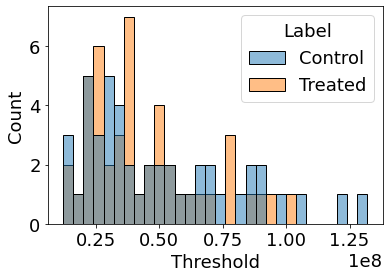

In [20]:
sns.histplot(x = 'Threshold', hue = 'Label', data = df_thresh, bins = 30)

dist1 =  df_thresh[df_thresh['Label'] == 'Control']['Threshold']
dist2 = df_thresh[df_thresh['Label'] == 'Treated']['Threshold']
comparison_distributions(dist1, dist2)